### Module import

In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

### Load image

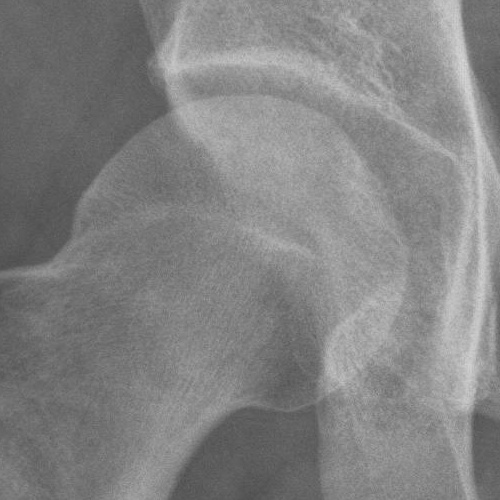

In [2]:
img_dir = './'
img_name = 'normalPXR_4_R_flip.jpg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [3]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

/home/wallis/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Define and create fastai custom head

In [4]:
from torch import Tensor
import logging as log
from typing import Optional # required for "Optional[type]"

class Flatten(torch.nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full

    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)

class AdaptiveConcatPool2d(torch.nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`." # from pytorch
    def __init__(self, sz:Optional[int]=None): 
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz or 1
        self.ap = torch.nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = torch.nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
def fastaihead(nf, nc):
    return \
    torch.nn.Sequential(        # the dropout is needed otherwise you cannot load the weights
            AdaptiveConcatPool2d(),
            Flatten(),
            torch.nn.BatchNorm1d(nf),
            torch.nn.Dropout(p=0.25, inplace=False),
            torch.nn.Linear(nf, 512, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(512, nc, bias=True),
            torch.nn.BatchNorm1d(nc),
        )

In [5]:
base_model=models.resnet34() 
base_module=list(base_model.children())
base_module.pop(-1) 
base_module.pop(-1)

temp=torch.nn.Sequential(torch.nn.Sequential(*base_module))
head_module=list(temp.children())
head_module.append(fastaihead(1024,2))

fastai_resnet34_arch=torch.nn.Sequential(*head_module)

#for k in fastai_resnet34_arch.state_dict(): print("Module Layer", k)

### Load weight into PyTorch for inference

In [6]:
loc = torch.load('./HumanOA_0930_Take4v3.pth', map_location=torch.device('cpu'))
#for k in loc['model']: print("layer", k)

In [7]:
fastai_resnet34_arch.load_state_dict(loc['model'])
fastai_resnet34_arch.eval()
fastai_resnet34_arch.cuda()

#target_layer = fastai_resnet34_arch._modules['0']._modules['7']

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### GradCAM & GradCAM++

In [8]:
cam_dict = dict()
fastai_resnet34_dict = dict(type='fastai_resnet34_arch', arch=fastai_resnet34_arch, layer_name='0', input_size=(500, 500))

In [9]:
fastai_resnet34_gradcam = GradCAM(fastai_resnet34_dict, True)
fastai_resnet34_gradcampp = GradCAMpp(fastai_resnet34_dict, True)

cam_dict['fastai_resnet34'] = [fastai_resnet34_gradcam, fastai_resnet34_gradcampp]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [10]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

### Save and show results 

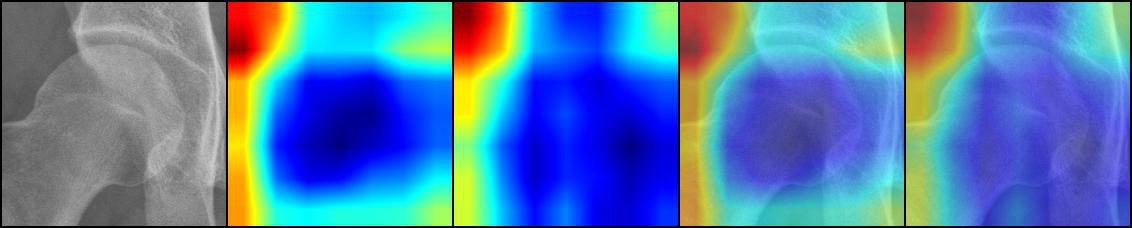

In [11]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)